Sarracenia Algorithmic Design
=========================

What were the issues with Sundew that led to Sarracenia?


* Problems/Weaknesses of Sundew

* Key Decisions for Sarracenia

  * Use Folders/Directories
  * Add a robust message queueing system.
  

Problems/Weaknesses of Sundew:
-------------------------------------------------

* push only, required someone else to send to us for us to receive.
  Senders always must configure who they are sending to.
  
* limited parallelism: each receiver or sender is a single process, only a single sender for a single destination.

* without dictionaries, the routing algorithm falls back on relatively expensive PDS routing.  Message routing (the cheap kind) was disappearing.

* internal design details, make the path names highly constrained (had to have colons in them, no folders, etc...)
  Nobody without very specific directory structures could use it.
  

Use Folders/Directories
----------------------------------

* Sundew used only the name of the file to make routing decisions.  
* Sarracenia uses the entire path.
  * It allows for any directory tree to be transferred, and for the 
  * all the directories in the tree to contribute to routing decisions. 
  * The entire path becomes file metadata. 
  * more compatible/adoptable for different file flows.
  

Add RabbitMQ
--------------------

Introduced rabbitmq/amqp broker. After years of study of performance (it was used as a pure dissemination tool, outside of Sundew for six years prior to start of work on Sarracenia, which made a message broker central to data routine.) We needed to ensured that, as a componentm it would scale reasonably well for our loads.

Using RabbitMQ, we introduced topic/based routing, as an analog to dictionary routing, but much more applicable to non-message traffic (aka files.) should improve routing decisions for files, while not hurting routing for messages too much. Product mix is much more file oriented than message oriented in recent times.

* topics provide a pre-filtering function that substantially reduces the amount of routing work done in the application. each sender now only has to check its own regexes.

* the topic matching is done by the broker, and the broker has it's own parallelization methods.

* by sharing of queues, can parallelize all transfers (except initial one), both reception and transmission.
  
* can obtain new products by subscribing to other data pumps. One is not restricted to only receiving data sent by others.

Introduced an architectural constraint or weakness in the form of a message broker. Introducing such components is a rare, exceptional event.

  * Use of message brokers do not introduce synchronization to an app. (messages are not locks.) they are queues so every process operates at it's own speed. 
  * It needs to be well done. RabbitMQ is well done. message brokers are hard.
  * scaling of rabbitmq is, in principle, possible, we have done so in some deployments.
  

Add RabbitMQ
---------------------

* topic based pre-routing.
* robust, high performance implementation with good internal design for multi-core.
* able to scale beyond one node.


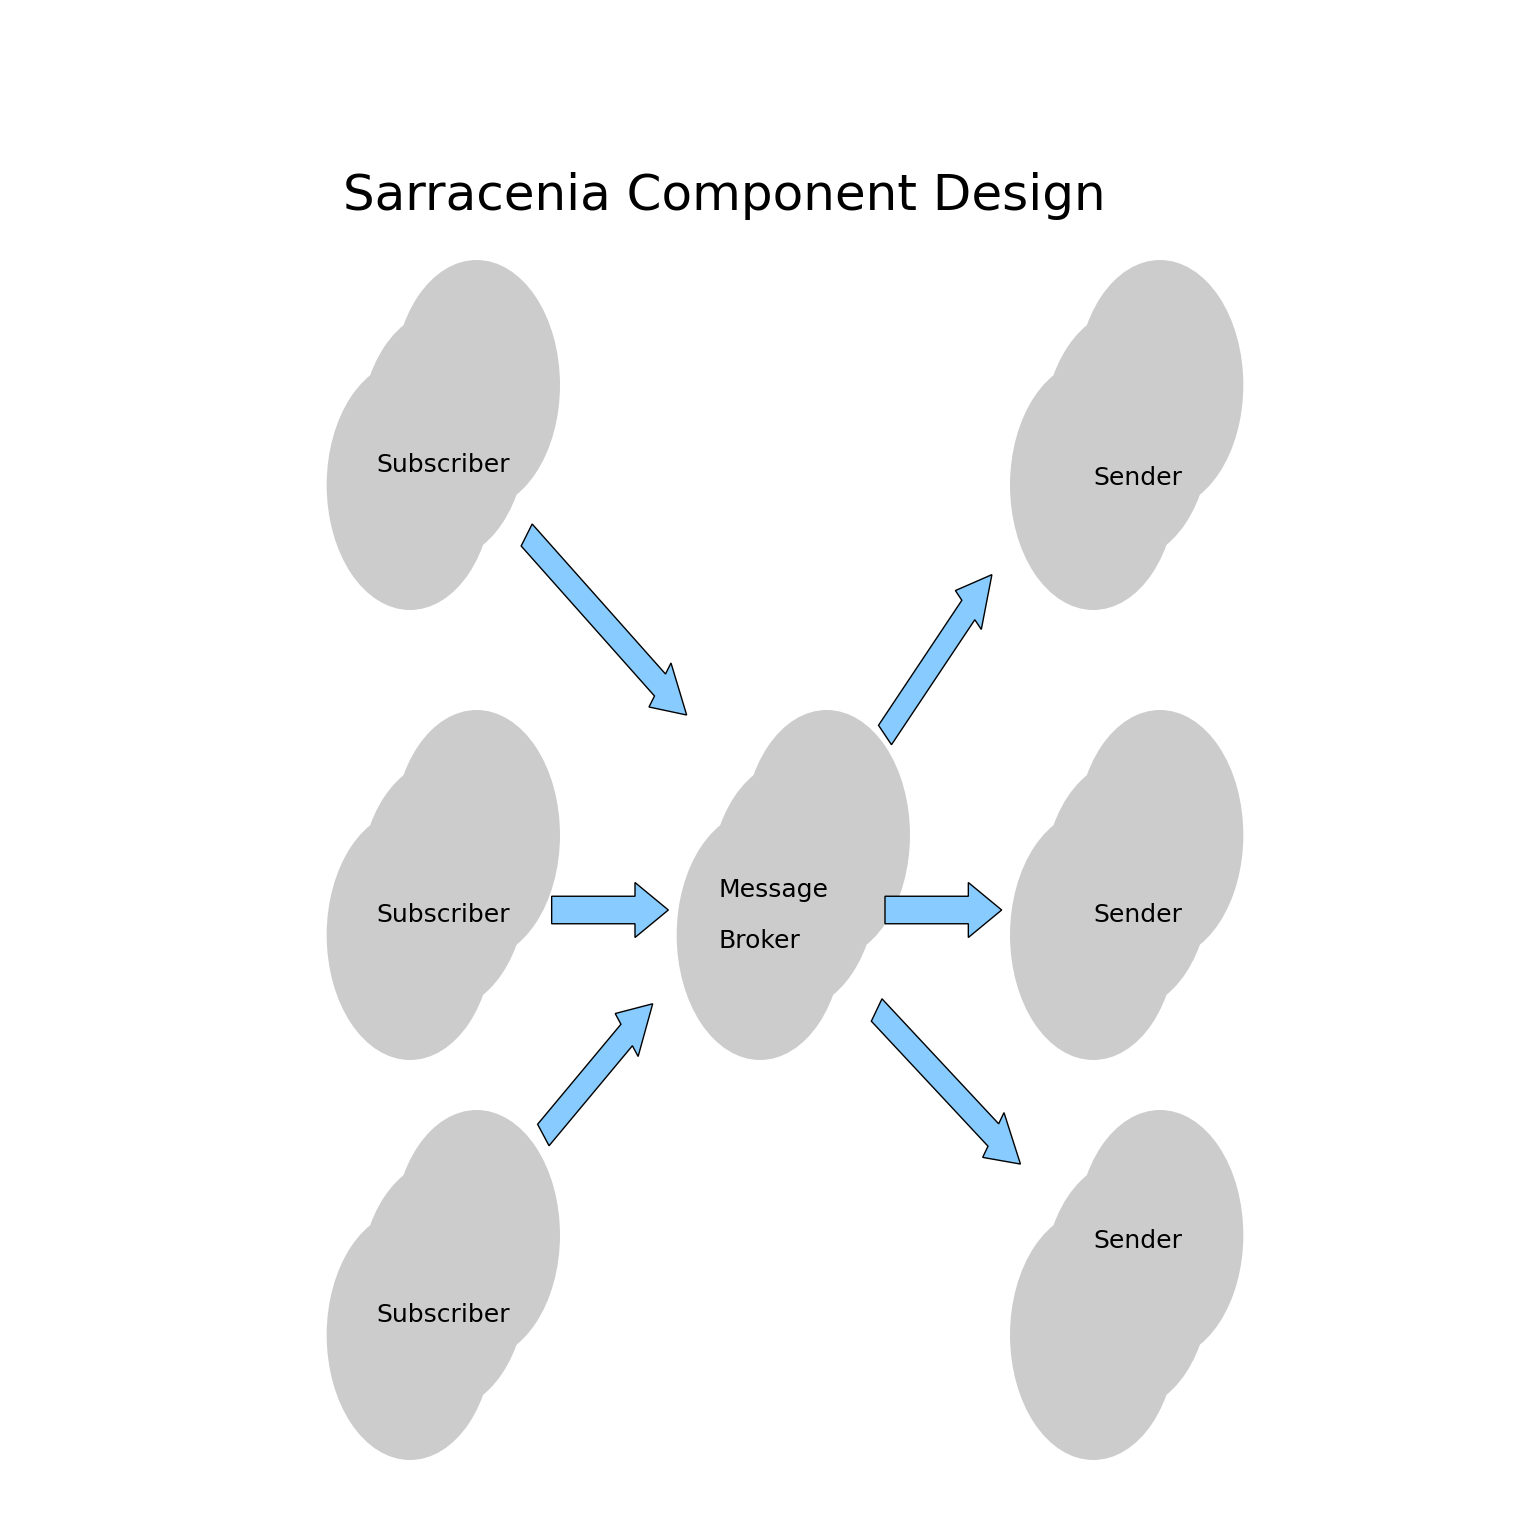

In [18]:
# make a fig here...
# should have multiple readers for queue...
# might show multiple subscribers for reading from different pumps.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow

def triple_circle(x,y,box_bg):
    return [
       Circle((x+0.4, y+0.9), 0.5, fc=box_bg),
       Circle((x+0.2, y+0.7), 0.5, fc=box_bg),
       Circle((x, y+0.5), 0.5, fc=box_bg)
    ]

def directory_polygon(x,y,box_bg,arrow1):
   return [
       Rectangle((x, y), 0.8, 1.1, zorder=1, fc=box_bg),
       Rectangle((x+0.2, y+0.2), 0.8, 1.1, zorder=2, fc=box_bg),
       Rectangle((x+0.4, y+0.4), 0.8, 1.1, zorder=3, fc=box_bg),
       FancyArrow(x+1.4,y+0.6, 0.35, 0, fc=arrow1, width=0.25, head_width=0.5, head_length=0.2)
       ]


def create_base(box_bg = '#CCCCCC',
                arrow1 = '#88CCFF',
                arrow2 = '#88FF88',
                supervised=True):
    
    fig = plt.figure(figsize=(15, 15), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),
                 xticks=[], yticks=[], frameon=False)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 6)
    
    x=0
    y=3.6
    patches = []
    
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))  
    patches.extend(triple_circle(x+2.4,y,box_bg))
    y=0.2
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))
    patches.extend(triple_circle(x+2.4,y,box_bg))
    y=1.8
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))
    patches.extend(triple_circle(x+2.4,y,box_bg))
    patches.extend(triple_circle(4.5, 1.8, box_bg))
    len=0.5
    patches.extend( 
        [ 
          FancyArrow(3.1, 3.9, len+0.3, -0.6, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(3.25, 2.4, len, 0, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(3.2, 1.5, len, +0.4, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
            
          FancyArrow(5.25, 3.1, len, +0.5, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(5.25, 2.4, len, 0, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(5.2, 2.0, len+0.2, -0.5, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 )
         
        ])
    patches.extend(triple_circle(6.5, 3.6, box_bg))
    patches.extend(triple_circle(6.5, 1.8, box_bg))
    patches.extend(triple_circle(6.5, 0.2, box_bg))
      
    for p in patches:
        ax.add_patch(p)
    plt.text(4.25,2.45, 'Message', fontsize=18)
    plt.text(4.25,2.25, 'Broker', fontsize=18)
    plt.text(2.2,0.75, 'Subscriber', fontsize=18)
    plt.text(2.2,2.35, 'Subscriber', fontsize=18)
    plt.text(2.2,4.15, 'Subscriber', fontsize=18)
    plt.text(6.5,1.05, 'Sender', fontsize=18)
    plt.text(6.5,2.35, 'Sender', fontsize=18)
    plt.text(6.5,4.1, 'Sender', fontsize=18)
create_base()
plt.text(2, 5.2, 'Sarracenia Component Design',fontsize=36)
plt.show()

In [20]:
"""

Estimating the cost to route 1 product, using topic based routing along with the traditional regular expressions.


"""
from math import log

K=10000   # number of topics/folders in the hierarchy
B=8       # branching level at each level in the hierarchy
n=10      # number of characters in a topic name
b=2       # number of bindings per sender
S=100     # number of senders


# routing cost on the broker, in integer ops.
# log(K,2)*n - lookup each topic in a dictionary to map it to an integer
# log(K,B)   - the depth of the higherarchy is a function of the total, and the number of choices at each level.
# log(B,2)   - the time to search each level in the hierarchy, comparing integers.
# 
Rpb = ( log(K,B)*(log(K,2)*n + log(B,2))*b*S )

# AMQP exchanges function as an additional topic in the higherarchy at the top of the tree.
# so they can be ignored.

print( f" the cost on the broker to route a single product: {int(Rpb)} in integer ops"  )

# this is pretty iffy, used this conversion throughout, but if RE's are much cheaper, then
# ... the numbers change alot.
# convert integer ops to regular expressions.  This is difficult to estimate
# https://swtch.com/~rsc/regexp/regexp1.html "Regular Expression Matching Can Be Simple And Fast (but is slow in Java, Perl, PHP, Python, Ruby, ...)" -- Russ Cox, rsc@swtch.com
# it lists O(m,l)
# 
m=30 # the length of the regex being matched to.
l=50 # the length of the string being matched.
RE=l*m

print( f"\nregex's are O(m,l) = {RE} hmm... sounds like too much.")
# Seems overly pessimistic, overriding.

RE=100

print( f"overriding source, lowering estimate to {RE} more investigation needed.")
      
# on the client side, in # of regex evals. 

s=10   #number of senders pre-routed to by the broker.
re=10  #number of regular expressions per sender to evaluate.

Rpc = s*RE*re/2

print( f"Assuming {s} senders selected by broker, each one needs to look at the {re}'s in it's configuration")

print( f"Client-side routing cost is {round(Rpc)}")

Rp=Rpb+Rpc

print( f"\nt total cost={round(Rp)}")




 the cost on the broker to route a single product: 120366 in integer ops

regex's are O(m,l) = 1500 hmm... sounds like too much.
overriding source, lowering estimate to 100 more investigation needed.
Assuming 10 senders selected by broker, each one needs to look at the 10's in it's configuration
Client-side routing cost is 5000

t total cost=125366


The Algorithmic Cost to Route 1 File
----------------------------------------------------


| Application|  Pr   | Client | Dominant Term/ compute cost scales as a function of      | Pre-Routing Done By   |
|------------|-------|--------|----------------------------------------------------------|-----------------------|
| PDS        |   500 |     50 | product of the number of receivers, senders, products    | One Dispatcher process|
| Sundew File|   500 |     50 | product of the number of senders, products               | All (10ish) receivers |
| Sundew Msg |    <1 |      5 | log of the number of messages                            | All (10ish) receivers |
| Sarracenia |   120 |      5 | log of the number of topics/folders                      | Message broker        |

* Units: Kilo Instructions per second.  500 = 0.5 MIPS.
* broker is a service, but is multiprocessing/scaled itself. not a single process.
* sender processes do the client-side routing in all cases.
* For Sundew, this number is optimistic (bulletin) case, file case is more like PDS, but multiple routers.
* for Sarracenia, this number applies to all routing.
* give scaling factors the large the configuration, the bigger the perf. advantage for topc routing.


In [ ]:

s=10 # number of senders / product shipped.
ServerPeak=1000

#for PDS
clientSide=1000/0.050 = 20000
Dispatcher=1000/0.5= 2000
PDSPeak=2000
# limited to slowest element, which is the dispatcher, so 2000 is upper bound.

#For Sundew
SundewClientSide=1000/0.005= 200000
SundewReceivers=1000/0.182 = 5494
SundewPeak=SundewReceivers*s=54940
# limited minimum of client and receivers, so 54.9 is it.

#For Sarra
SarraClientSide=1000/0.005 = 200000
SarraBroker= 1000/0.125 = 8000.0
# how many cpus can a broker use to route? um... it isn't limited.. or is at least unknown...
# hmm... defined by the broker implementation.lets just use s.
SarraPeak= SarraBroker*s= 80000



Overall Server Algorithmic Ceiling
-------------------------------------------------


Assume a 1 GIPS machine within infinite cpus, and take IP cost per route, so the number of products that can be routed by a server is going to be inverely related to cost to route each one:  route/second = 1000 MIPS / cost to route from previous cell. The other contributor is the number of processes doing the routing.

| Application | Route/s  | Routers |  Total |
|-------------|----------|---------|--------|
| PDS         |  2000    | 1+10    |   2000 |
| Sundew      |  5494    | 10+10   |  54940 |
| Sarracenia  |  8000    | 10+10   |  80000 |


* These numbers are algorithmic maxima, never to be seen in real life.
* The Sarracenia one requires a guess at parallelization of Rabbitmq, is conservative.


Duplicate Suppression
===================

* All message passing networks implement "Duplicate Suppression"

* typical:
  * checksum the message, store the checksums.
  * when you get a new message compare it's checksum to what is in the store.
  * if there is a hit, then it's a duplicate, so discard the message.
  
* Does not need to be perfect...
  * a few duplicates is ok, but need to prevent "storms"
  
* Simple if one process is handling an entire flow.

* Not simple if > 1 process share the flow.



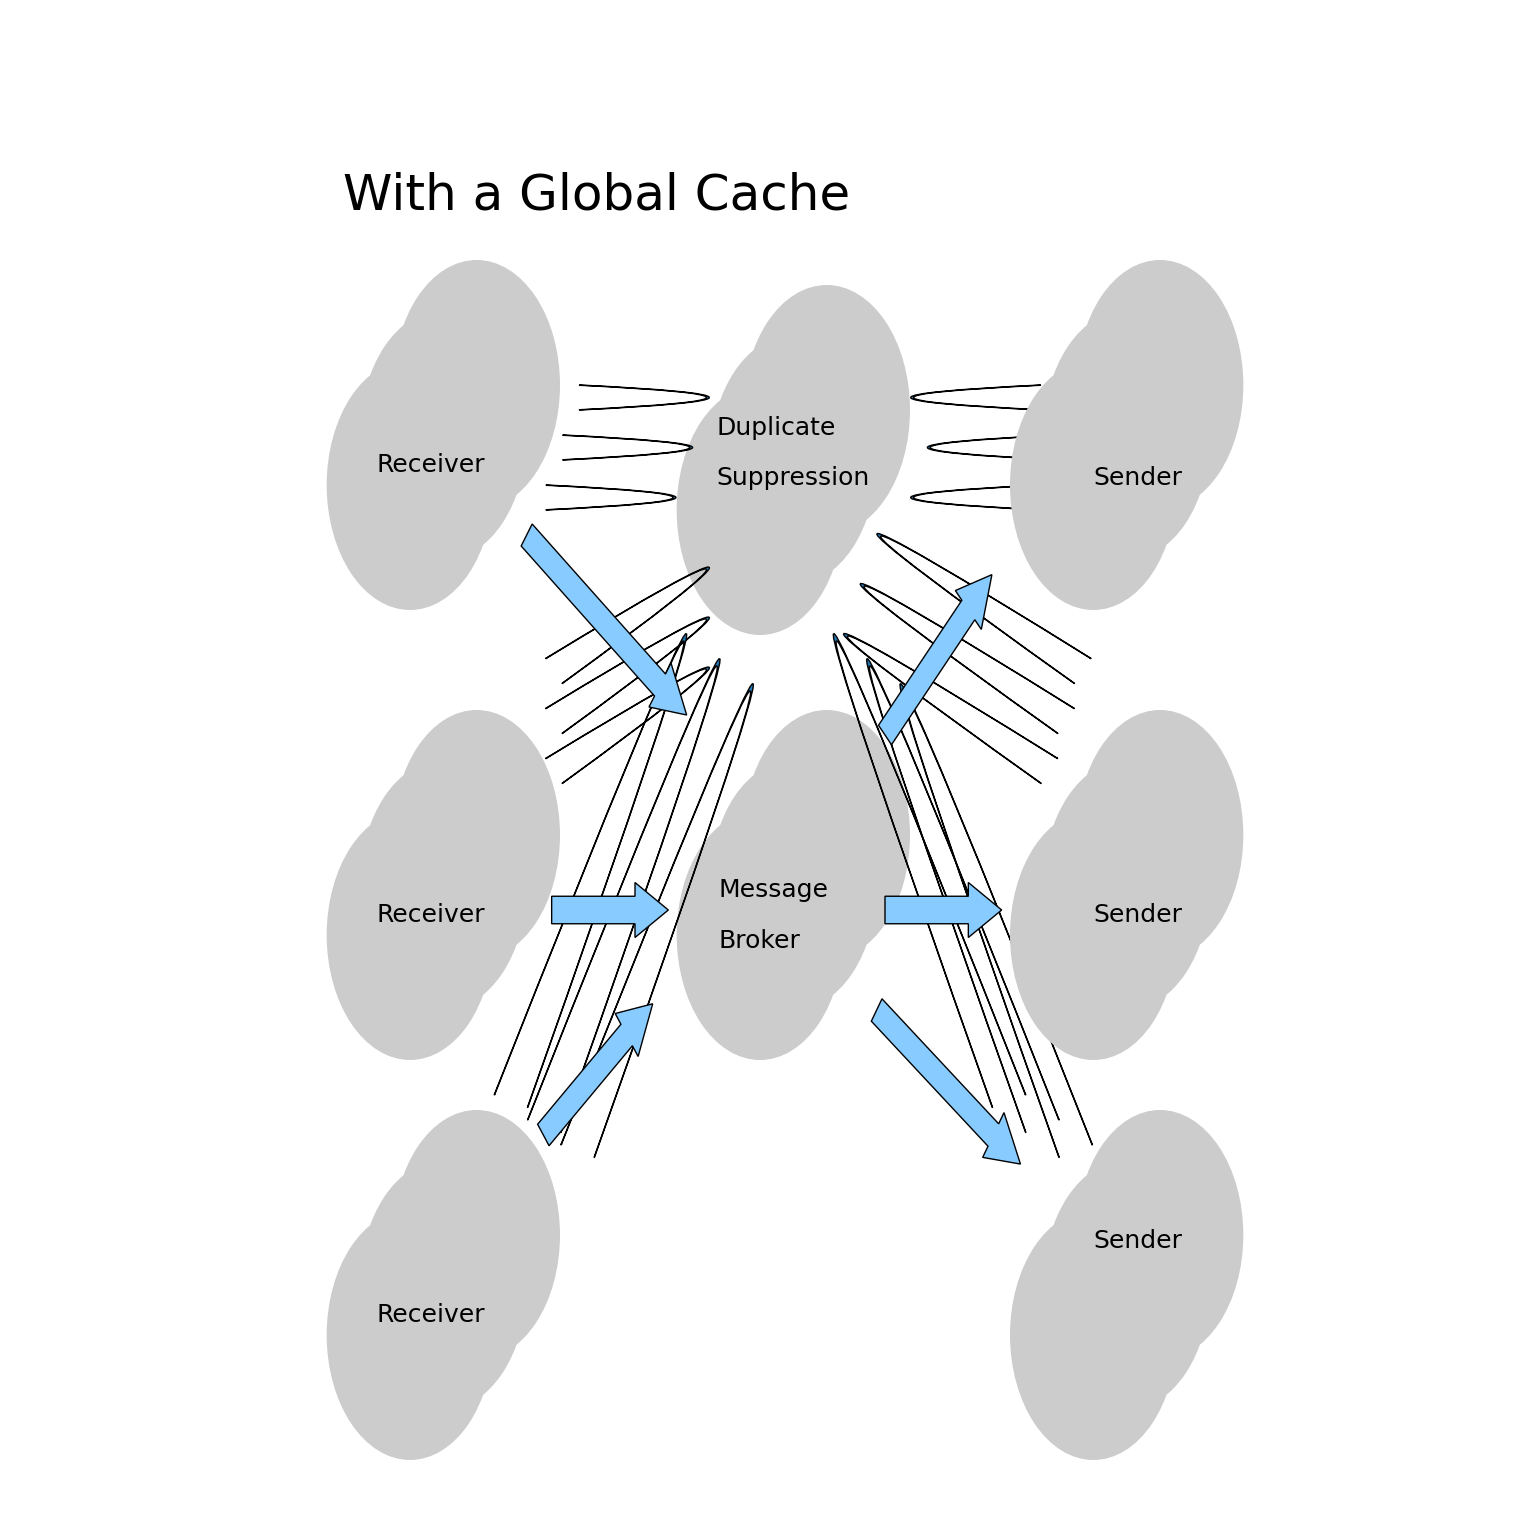

In [16]:
# make a fig with a global cache.
# make a fig here...
# should have multiple readers for queue...
# might show multiple subscribers for reading from different pumps.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow, FancyArrowPatch

def triple_circle(x,y,box_bg):
    return [
       Circle((x+0.4, y+0.9), 0.5, fc=box_bg),
       Circle((x+0.2, y+0.7), 0.5, fc=box_bg),
       Circle((x, y+0.5), 0.5, fc=box_bg)
    ]

def directory_polygon(x,y,box_bg,arrow1):
   return [
       Rectangle((x, y), 0.8, 1.1, zorder=1, fc=box_bg),
       Rectangle((x+0.2, y+0.2), 0.8, 1.1, zorder=2, fc=box_bg),
       Rectangle((x+0.4, y+0.4), 0.8, 1.1, zorder=3, fc=box_bg),
       FancyArrow(x+1.4,y+0.6, 0.35, 0, fc=arrow1, width=0.25, head_width=0.5, head_length=0.2)
       ]


def create_base(box_bg = '#CCCCCC',
                arrow1 = '#88CCFF',
                arrow2 = '#88FF88',
                supervised=True):
    
    fig = plt.figure(figsize=(15, 15), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),
                 xticks=[], yticks=[], frameon=False)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 6)
    
    x=0
    y=3.6
    patches = []
    
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))  
    patches.extend(triple_circle(x+2.4,y,box_bg))
    y=0.2
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))
    patches.extend(triple_circle(x+2.4,y,box_bg))
    y=1.8
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))
    patches.extend(triple_circle(x+2.4,y,box_bg))
    patches.extend(triple_circle(4.5, 1.8, box_bg))
    patches.extend(triple_circle(4.5, 3.5, box_bg))

    len=0.5
    patches.extend( 
        [ 
          FancyArrowPatch( (3.4,4.4), (3.4,4.5), connectionstyle="arc3,rad=10.5" ),
          FancyArrowPatch( (3.3,4.2), (3.3,4.3), connectionstyle="arc3,rad=10.5" ),
          FancyArrowPatch( (3.2,4.0), (3.2,4.1), connectionstyle="arc3,rad=10.5" ),
            
          FancyArrowPatch( (6.2,4.4), (6.2,4.5), connectionstyle="arc3,rad=-10.5" ),
          FancyArrowPatch( (6.3,4.2), (6.3,4.3), connectionstyle="arc3,rad=-10.5" ),
          FancyArrowPatch( (6.2,4.0), (6.2,4.1), connectionstyle="arc3,rad=-10.5" ), 
            
          FancyArrowPatch( (6.4,3.3), (6.5,3.4), connectionstyle="arc3,rad=-16.5" ),
          FancyArrowPatch( (6.3,3.1), (6.4,3.2), connectionstyle="arc3,rad=-16.5" ),
          FancyArrowPatch( (6.2,2.9), (6.3,3.0), connectionstyle="arc3,rad=-16.5" ),  
           
          FancyArrowPatch( (3.3,3.3), (3.2,3.4), connectionstyle="arc3,rad=12.5" ),
          FancyArrowPatch( (3.3,3.1), (3.2,3.2), connectionstyle="arc3,rad=12.5" ),
          FancyArrowPatch( (3.3,2.9), (3.2,3.0), connectionstyle="arc3,rad=12.5" ), 
            
          FancyArrowPatch( (3.1,1.6), (2.9,1.65), connectionstyle="arc3,rad=28" ),
          FancyArrowPatch( (3.3,1.5), (3.1,1.55), connectionstyle="arc3,rad=28" ),
          FancyArrowPatch( (3.5,1.4), (3.3,1.45), connectionstyle="arc3,rad=28" ),  
            
          FancyArrowPatch( (5.9,1.6), (6.1,1.65), connectionstyle="arc3,rad=-28" ),
          FancyArrowPatch( (6.1,1.5), (6.3,1.55), connectionstyle="arc3,rad=-28" ),
          FancyArrowPatch( (6.3,1.4), (6.5,1.45), connectionstyle="arc3,rad=-28" ),  
            
            
            
          FancyArrow(3.1, 3.9, len+0.3, -0.6, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(3.25, 2.4, len, 0, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(3.2, 1.5, len, +0.4, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
            
          FancyArrow(5.25, 3.1, len, +0.5, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(5.25, 2.4, len, 0, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(5.2, 2.0, len+0.2, -0.5, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 )
         
        ])
    patches.extend(triple_circle(6.5, 3.6, box_bg))
    patches.extend(triple_circle(6.5, 1.8, box_bg))
    patches.extend(triple_circle(6.5, 0.2, box_bg))
      
    for p in patches:
        ax.add_patch(p)
    plt.text(4.25,2.45, 'Message', fontsize=18)
    plt.text(4.25,2.25, 'Broker', fontsize=18)
    plt.text(4.24,4.3, 'Duplicate', fontsize=18)
    plt.text(4.24,4.1, 'Suppression', fontsize=18)
    plt.text(2.2,0.75, 'Receiver', fontsize=18)
    plt.text(2.2,2.35, 'Receiver', fontsize=18)
    plt.text(2.2,4.15, 'Receiver', fontsize=18)
    plt.text(6.5,1.05, 'Sender', fontsize=18)
    plt.text(6.5,2.35, 'Sender', fontsize=18)
    plt.text(6.5,4.1, 'Sender', fontsize=18)
create_base()
plt.text(2, 5.2, 'With a Global Cache',fontsize=36)
plt.show()


Global Duplication Suppression
---------------------------------------------

* create a service for all the processes participating in a flow to contact.
* ask the service if a partipant has already seen a message with this checksum.
* if the answer is yet, discard the message.
* totally global is the worst case.




Distributed Duplicate Suppression
-------------------------------------------------

* hash the checksum to get a modulo N
* publish the message to an array of destinations modulo the checksum
* a single subscriber on each destination will get 1/N messages.
* Every occurrence of the same message will be sent to the same subscriber.


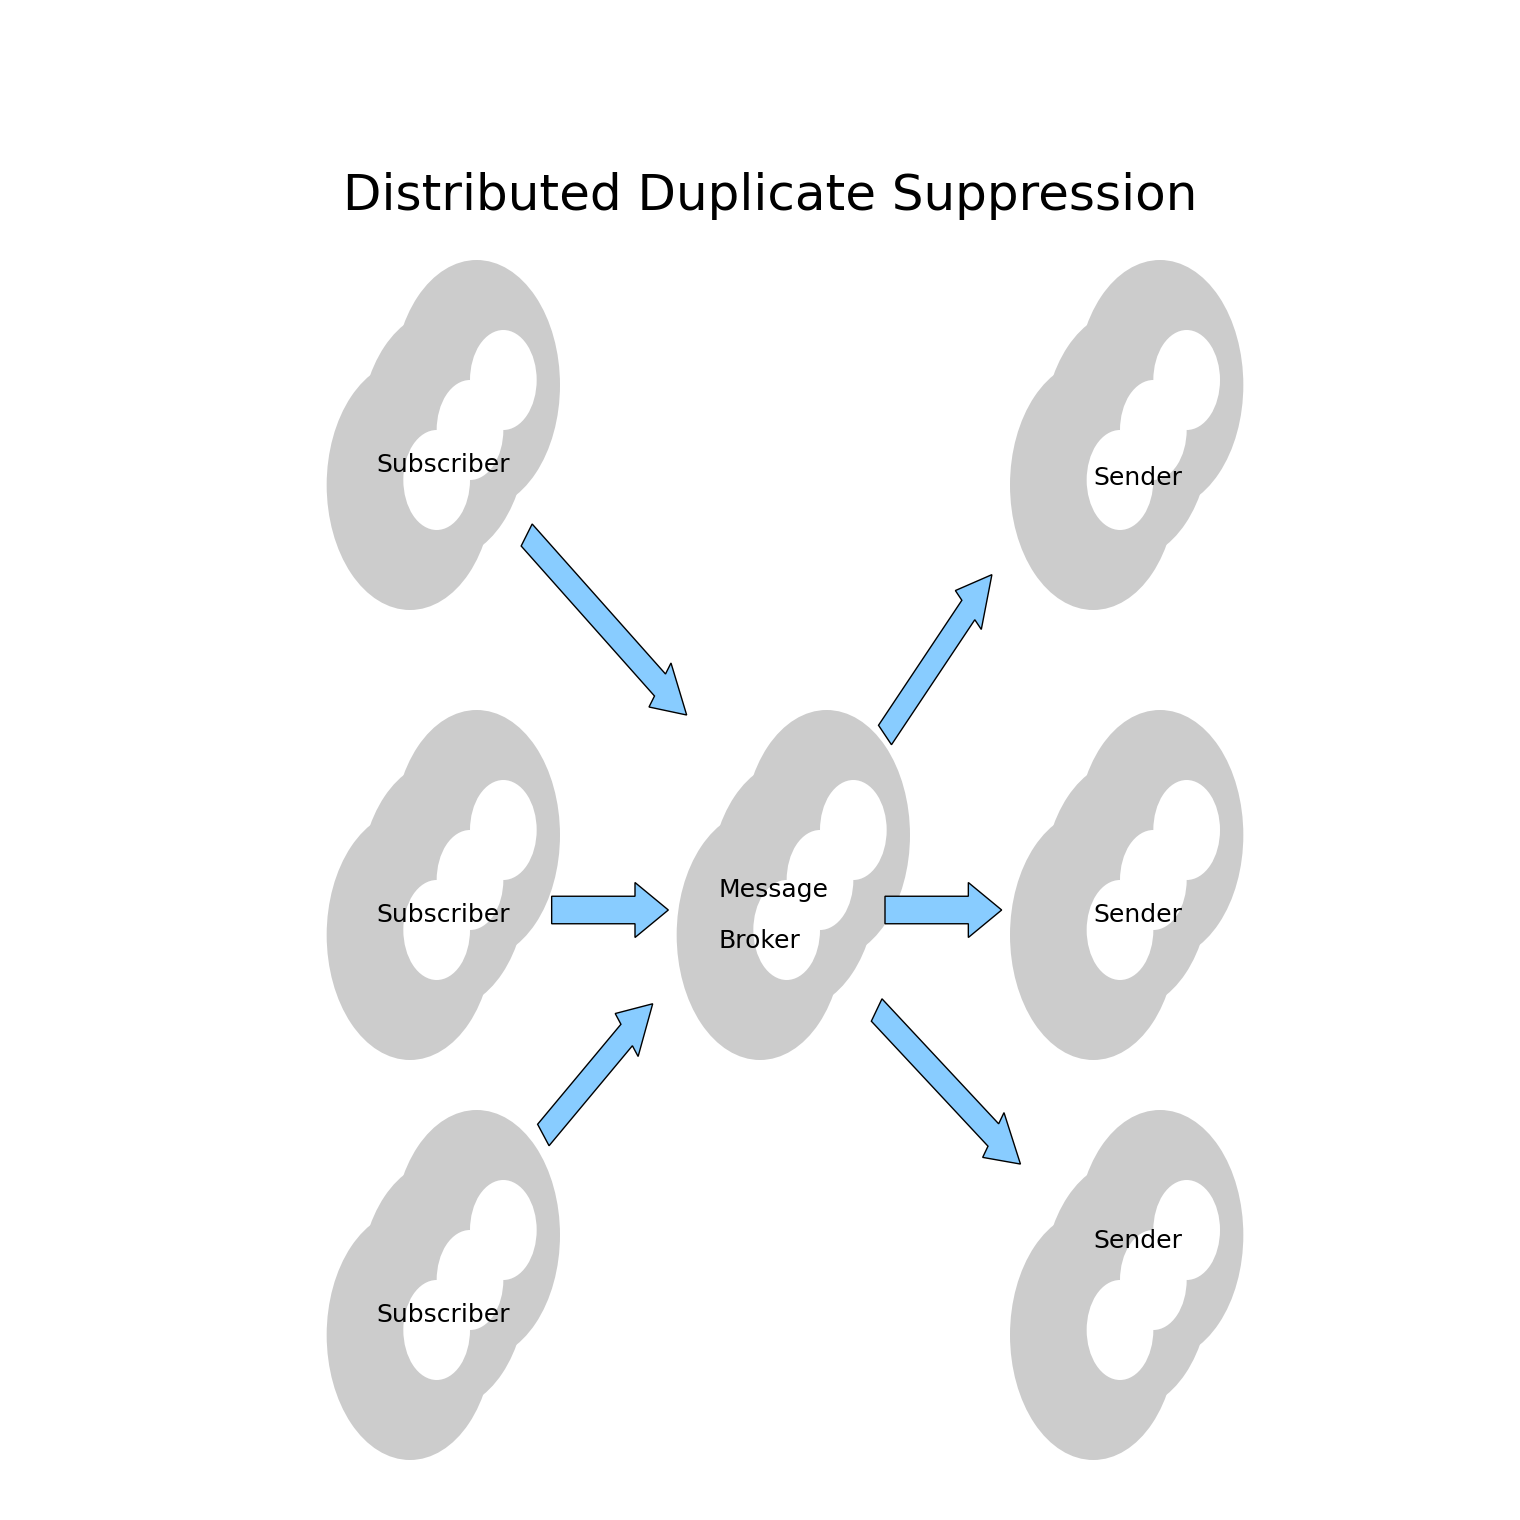

In [17]:
# make a fig here...
# should have multiple readers for queue...
# might show multiple subscribers for reading from different pumps.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow

def triple_circle(x,y,box_bg):
    return [
       Circle((x+0.4, y+0.9), 0.5, fc=box_bg),
       Circle((x+0.2, y+0.7), 0.5, fc=box_bg),
       Circle((x, y+0.5), 0.5, fc=box_bg),
        
       Circle((x+0.16, y+0.52), 0.2, fc="white"),
       Circle((x+0.36, y+0.72), 0.2, fc="white"),
       Circle((x+0.56, y+0.92), 0.2, fc="white")
    ]

def directory_polygon(x,y,box_bg,arrow1):
   return [
       Rectangle((x, y), 0.8, 1.1, zorder=1, fc=box_bg),
       Rectangle((x+0.2, y+0.2), 0.8, 1.1, zorder=2, fc=box_bg),
       Rectangle((x+0.4, y+0.4), 0.8, 1.1, zorder=3, fc=box_bg),
       FancyArrow(x+1.4,y+0.6, 0.35, 0, fc=arrow1, width=0.25, head_width=0.5, head_length=0.2)
       ]


def create_base(box_bg = '#CCCCCC',
                arrow1 = '#88CCFF',
                arrow2 = '#88FF88',
                supervised=True):
    
    fig = plt.figure(figsize=(15, 15), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),
                 xticks=[], yticks=[], frameon=False)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 6)
    
    x=0
    y=3.6
    patches = []
    
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))  
    patches.extend(triple_circle(x+2.4,y,box_bg))
    y=0.2
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))
    patches.extend(triple_circle(x+2.4,y,box_bg))
    y=1.8
    #patches.extend(directory_polygon(x,y,box_bg,arrow1))
    patches.extend(triple_circle(x+2.4,y,box_bg))
    patches.extend(triple_circle(4.5, 1.8, box_bg))
    len=0.5
    patches.extend( 
        [ 
          FancyArrow(3.1, 3.9, len+0.3, -0.6, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(3.25, 2.4, len, 0, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(3.2, 1.5, len, +0.4, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
            
          FancyArrow(5.25, 3.1, len, +0.5, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(5.25, 2.4, len, 0, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(5.2, 2.0, len+0.2, -0.5, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 )
         
        ])
    patches.extend(triple_circle(6.5, 3.6, box_bg))
    patches.extend(triple_circle(6.5, 1.8, box_bg))
    patches.extend(triple_circle(6.5, 0.2, box_bg))
      
    for p in patches:
        ax.add_patch(p)
    plt.text(4.25,2.45, 'Message', fontsize=18)
    plt.text(4.25,2.25, 'Broker', fontsize=18)
    plt.text(2.2,0.75, 'Subscriber', fontsize=18)
    plt.text(2.2,2.35, 'Subscriber', fontsize=18)
    plt.text(2.2,4.15, 'Subscriber', fontsize=18)
    plt.text(6.5,1.05, 'Sender', fontsize=18)
    plt.text(6.5,2.35, 'Sender', fontsize=18)
    plt.text(6.5,4.1, 'Sender', fontsize=18)
create_base()
plt.text(2, 5.2, 'Distributed Duplicate Suppression',fontsize=36)
plt.show()

Each process has it's own duplicate suppression (the white component within each instance.) As The number of instances grow, the duplicate suppression performance grows naturally. This meets the "embarassingly parallel" goal. but it does cost complexity for analysts to set up.

Observations
----------------

* If you are going to use a global cache, it better be really good.
   * need to have a scaling architecture for the cache itself.
* If you are using a distributed cache, a fair one is fine.
   * scales with the data transmission naturally.
   * overall performance is far less sensitive to it's performance.
   